# Fitting of Logarithmic spirals to Galaxy-Builder data

Now we have our clusters, we can make comparisons between what a log spiral fit and a spline fit!

Need to come up with a metric of how well it matches the image though...

First, say the jupyter magic words 🧙‍

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import the plethora of useful modules we'll need (including some we probably don't)

In [2]:
import os
from tempfile import NamedTemporaryFile
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import Ellipse
from PIL import Image
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter
from skimage import img_as_float
from skimage.transform import rotate, rescale
from skimage.measure import compare_ssim as ssim
import astropy.units as u
from gzbuilderspirals import deprojecting as dpj
from gzbuilderspirals import getDrawnArms, deprojectArm, rThetaFromXY, xyFromRTheta
from gzbuilderspirals.galaxySpirals import GalaxySpirals
import sdssCutoutGrab as scg
import createSubjectsFunctions as csf

Open the NSA catalog, and the galaxy builder subjects and classifications

In [3]:
print('Loading NSA catalog')
nsa = fits.open('../../subjectUpload/nsa_v1_0_1.fits')

nsa_keys = [
    'NSAID', 'ISDSS', 'INED', 'RA', 'DEC', 'Z', 'SERSIC_BA', 'SERSIC_PHI', 'PETRO_THETA',
    'IAUNAME', 'ZDIST', 'RUN', 'CAMCOL', 'FIELD', 'RERUN',
]
nsaRas = nsa[1].data['ra']
nsaDecs = nsa[1].data['dec']

df_nsa = pd.DataFrame(
    {key: nsa[1].data[key].byteswap().newbyteorder() for key in nsa_keys}
)

print('Loading Zooniverse classification dump')
classifications = pd.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pd.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
null = None
true = True
false = False

print('Obtaining available frame montages')
# Some galaxies were montaged when created. Create a list of their coordinates for use later
montages = [f for f in os.listdir('montageOutputs') if not f[0] == '.']
montageCoordinates = np.array([
    [float(j) for j in i.replace('+', ' ').split(' ')]
    if '+' in i
    else [float(j) for j in i.replace('-', ' -').split(' ')]
    for i in [f for f in os.listdir('montageOutputs') if not f[0] == '.']
])

Loading NSA catalog
Loading Zooniverse classification dump
Obtaining available frame montages


Define the subject Id we'll be working on (parametrised using papermill)

In [4]:
subjectId = 20902039

Get the data for this galaxy (including deprojecting it). Code copied from the `spiralextraction.py` script

Working on galaxy 20902039
	- USING MONTAGED IMAGE
	- Getting galaxy rotation
[createWCSObject] Checking for transformation
[createWCSObject] Using CD
	- Downloading Zooniverse image
	- Deprojecting image
	- Extracting spiral annotations
Done!


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/tlingard/PhD/gzbuilderspirals/gzbuilderspirals/deprojecting.py:24: RuntimeWarning: cdelt will be ignored since cd is present
  fits_cdelt = wFits.wcs.cdelt
/Users/tlingard/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


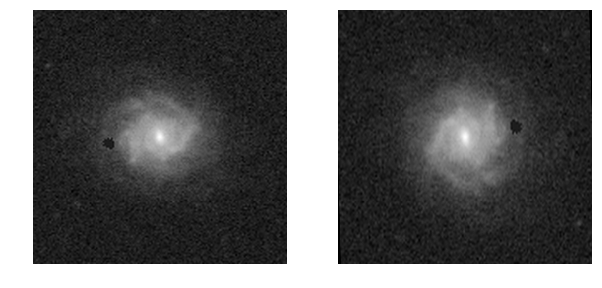

In [5]:
print('Working on galaxy {}'.format(subjectId))

# Grab the metadata of the subject we are working on
meta = eval(subjects[subjects['subject_id'] == subjectId].iloc[0]['metadata'])

# And the NSA data for the galaxy (if it's a galaxy with NSA data,
# otherwise throw an error)
try:
    gal = df_nsa[df_nsa['NSAID'] == int(meta['NSA id'])]
except KeyError:
    gal = {}
    raise KeyError('Metadata does not contain valid NSA id (probably an older galaxy)')

# Now we need to obtain the galaxy's rotation in Zooniverse image
# coordinates. This is made trickier by some decision in the subject
# creation pipeline.

# First, use a WCS object to obtain the rotation in pixel coordinates, as
# would be obtained from `fitsFile[0].data`

montagesDistanceMask = np.add.reduce(
    (montageCoordinates - [gal['RA'].iloc[0], gal['DEC'].iloc[0]])**2,
    axis=1
) < 0.01
usingMontage = np.any(montagesDistanceMask)
if usingMontage:
    montageFolder = montages[
        np.where(montagesDistanceMask)[0][0]
    ]
    fitsName = '{}/{}/{}'.format(
        os.path.abspath('montageOutputs'),
        montageFolder,
        'mosaic.fits'
    )
    print('\t- USING MONTAGED IMAGE')
else:
    fitsName = 'fitsImages/{0}/{1}/frame-r-{0:06d}-{1}-{2:04d}.fits'.format(
        int(gal['RUN']),
        int(gal['CAMCOL']),
        int(gal['FIELD'])
    )

print('\t- Getting galaxy rotation')
w = dpj.createWCSObject(gal, 512)
angle = dpj.getAngle(gal, fitsName, np.array([512, 512]))

print('\t- Downloading Zooniverse image')
# We'll now download the Zooniverse image that volunteers actually classified on
getUrl = lambda id: eval(subjects[subjects['subject_id'] == subjectId]['locations'].iloc[0])['1']
url = getUrl(subjectId)
imgData = requests.get(url).content

f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
f.write(imgData)
f.close()
pic = Image.open(f.name)
os.unlink(f.name)

# Grab the data arrays from the Image objects, and imshow the images (for debugging purposes)
picArray = np.array(pic)

print('\t- Deprojecting image')
# Now deproject the image of the galaxy:
rotatedImage = rotate(picArray, angle)
stretchedImage = rescale(
    rotatedImage,
    (1/gal['SERSIC_BA'].iloc[0], 1),
    mode='constant',
    multichannel=False
)
n = int((stretchedImage.shape[0] - np.array(pic).shape[0]) / 2)
if n > 0:
    deprojectedImage = stretchedImage[n:-n, :]
else:
    deprojectedImage = stretchedImage.copy()

print('\t- Extracting spiral annotations')
# Onto the clustering and fitting
# Extract the drawn arms from classifications for this galaxy
drawnArms = getDrawnArms(subjectId, classifications)
print('Done!')

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(picArray, origin='lower', cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(deprojectedImage, origin='lower', cmap='gray')
plt.axis('off')
None

We'll make use of the `gzbuilderspirals` class method to cluster arms.
First, initialise a `GalaxySpirals` object with the arms and deprojection
parameters.

Perform the spiral clustering:

In [6]:
s = GalaxySpirals(drawnArms, ba=gal['SERSIC_BA'].iloc[0], phi=-angle)

# Now calculate a the distance matrix for the drawn arms (this can be slow)
try:
    distances = np.load('distances/subject-{}.npy'.format(subjectId))
    print('Using saved distances')
except OSError:
    print('Calculating distances')
    distances = s.calculateDistances()
    np.save('distances/subject-{}.npy'.format(subjectId), distances)

# Perform the clustering (using the DBSCAN clustering algorithm)
db = s.clusterLines(distances)

Using saved distances


Fit both XY and radial splines to the resulting clusters (described in more detail in the method paper)

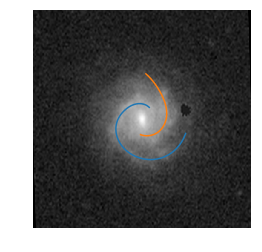

In [7]:
xyFits = s.fitXYSplines()
result = s.fitRadialSplines()

plt.imshow(deprojectedImage, cmap='gray', origin='lower')
for i, arm in enumerate(result['radialFit']):
    plt.plot(
        *s.arms[i].deNorm(arm).T
    )
plt.axis('off')
None

# Fitting a Log spiral

We'll just work on one arm. First, define what a log spiral is:
$$$
r = a~e^{b~\theta}
$$$
or, in x and y:
$$$
x = a \cos{\theta}~e^{b~\theta};\;y = a \sin{\theta}~e^{b~\theta} 
$$$

They are characterised by a constant pitch angle given by

$$$
\psi = \tan^{-1}\left(\frac{\frac{\mathrm{d}r}{\mathrm{d}\theta}}{r}\right) = \tan^{-1}\left(\frac{rb}{r}\right) = \tan^{-1}b
$$$


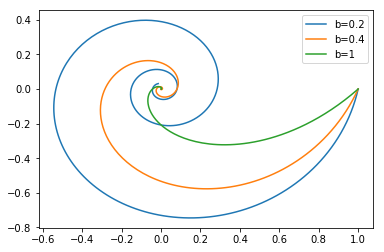

In [8]:
# Get r given theta (N -> N)
def logSpiral(theta, a=1, b=1):
    return a * np.exp(b * theta)

# Get x and y given theta. Returns pairs of coordinates (N -> (N, 2))
def logSpiralXY(theta, a=1, b=1):
    return np.stack((
        a * np.cos(theta) * np.exp(b * theta),
        a * np.sin(theta) * np.exp(b * theta),
    ), axis=1)

for b in [0.2, 0.4, 1]:
    spiral = logSpiralXY(
        np.linspace(2, 6*np.pi, 500),
        b=b
    )
    spiral /= np.max(spiral)
    plt.plot(
        *spiral.T,
        label='b={}'.format(b)
    )

plt.legend()

We will use this equation, along with the `getDistAlongPolyline` function in `gzbuilderspirals` to guide our fit. Fist let's make a plot with some decent starting parameters (including adding our theta range)

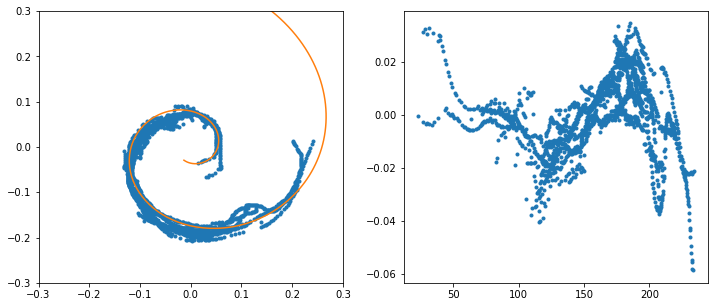

In [39]:
from gzbuilderspirals.ordering import getDistAlongPolyline

arm = result['deprojectedArms'][0]
points = arm.normalise(arm.cleanedCloud)
spiral = logSpiralXY(
    np.linspace(-2, 5*np.pi, 500),
    a=0.05338689,
    b=0.25113212
)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(*points.T, '.')
plt.plot(
    *spiral.T,
    label='b={}'.format(b)
)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.subplot(122)
plt.plot(*getDistAlongPolyline(points, spiral), '.'); None

In [10]:
from scipy.optimize import least_squares
from sklearn.linear_model import BayesianRidge


def wrapper(p, theta=np.linspace(-2, 5*np.pi, 500)):
    spiral = logSpiralXY(
        theta,
        a=p[0],
        b=p[1]
    )
    return getDistAlongPolyline(points, spiral)[1]

ret = least_squares(wrapper, [0.05, 0.25], loss='soft_l1')

In [11]:
ret['x']

array([0.05338689, 0.25113212])

Resulting pitch angle: 14.097277444581048


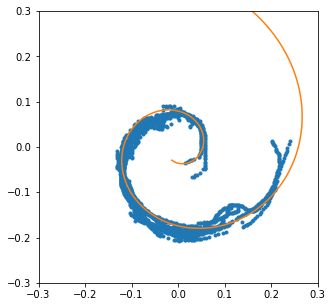

In [12]:
a, b = ret['x']
points = arm.normalise(arm.cleanedCloud)
spiral = logSpiralXY(
    np.linspace(-2, 5*np.pi, 500),
    a=a,
    b=b
)
plt.figure(figsize=(5, 5))
plt.plot(*points.T, '.')
plt.plot(
    *spiral.T,
)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
None

print('Resulting pitch angle: {}'.format(np.rad2deg(np.arctan(b))))

Resulting pitch angle 2: 14.9


(-0.3, 0.3)

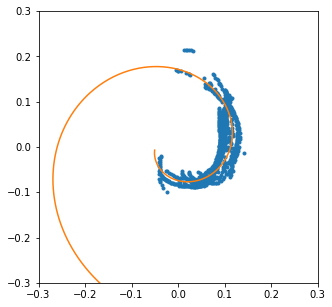

In [13]:
arm2 = result['deprojectedArms'][1]
points2 = arm2.normalise(arm2.cleanedCloud)

# theta is different to that in wrapper1 due to the rotational offset of the spiral
def wrapper2(p, theta=np.linspace(-3, 2*np.pi, 500)):
    spiral = logSpiralXY(
        theta,
        a=p[0],
        b=p[1]
    )
    return getDistAlongPolyline(points2, spiral)[1]

ret2 = least_squares(wrapper2, [0.11, 0.3], loss='soft_l1')
a2, b2 = ret2['x']
print('Resulting pitch angle 2: {:.1f}'.format(np.rad2deg(np.arctan(b2))))

spiral2 = logSpiralXY(
    np.linspace(-3, 2*np.pi, 500),
    a=a2,
    b=b2
)
plt.figure(figsize=(5, 5))
plt.plot(*points2.T, '.')
plt.plot(
    *spiral2.T,
)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)


## Plotting it together

Let's plot the points, splines and log spirals together!

(-0.5, 0.5)

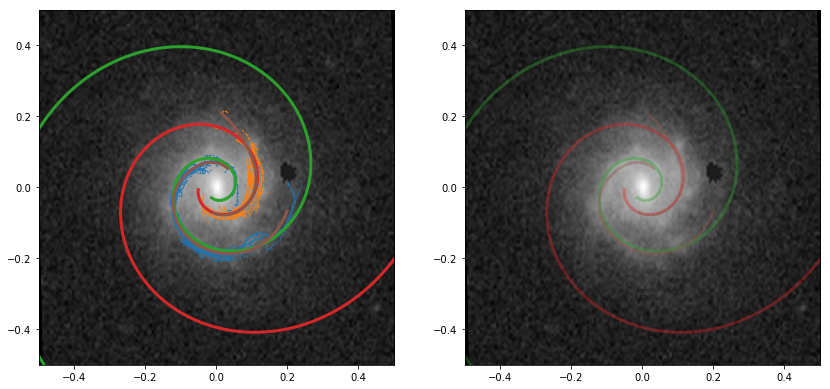

In [14]:
plt.figure(figsize=(14, 10))
plt.subplot(121)
plt.imshow(deprojectedImage, cmap='gray', origin='lower', extent=[-0.5, 0.5, -0.5, 0.5])
for i, dpjArm in enumerate(result['deprojectedArms']):
    points = dpjArm.normalise(dpjArm.cleanedCloud)
    plt.plot(*points.T, '.', c='C{}'.format(i), markersize=1)

plt.plot(*spiral.T, c='C2', linewidth=3)
plt.plot(*spiral2.T, c='C3', linewidth=3)

for radialFit in result['radialFit']:
    plt.plot(*radialFit.T, c='C{}'.format(i + 4), linewidth=3)
    
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)

plt.subplot(122)
plt.imshow(deprojectedImage, cmap='gray', origin='lower', extent=[-0.5, 0.5, -0.5, 0.5])

plt.plot(*spiral.T, c='C2', linewidth=3, alpha=0.4 )
plt.plot(*spiral2.T, c='C3', linewidth=3, alpha=0.4)

for radialFit in result['radialFit']:
    plt.plot(*radialFit.T, c='C{}'.format(i + 4), linewidth=3, alpha=0.4)
    
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)


(0, 0.5)

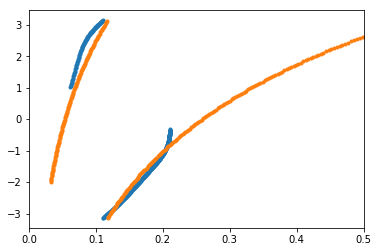

In [15]:
r, theta = rThetaFromXY(*result['radialFit'][0].T)
r2, theta2 = rThetaFromXY(*spiral.T)
plt.plot(r, theta, '.')
plt.plot(r2, theta2, '.')
plt.xlim(0, 0.5)


14.091236929902834 14.091236929903602


(0, 0.3)

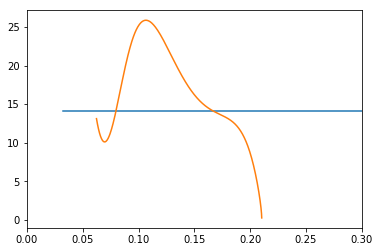

In [16]:
x = [.1, .2, .5, .6, .7, .8, .9]
y = [1, 2, 3, 4, 4, 5, 6]


d = spiral[2:] - spiral[:-2]
dydx = d[:, 1] / d[:, 0]

r, theta = rThetaFromXY(*spiral.T)

foo =np.rad2deg(
    theta[1:-1] - np.arctan(dydx) + np.pi/2
)%180

print(min(foo), max(foo))
plt.plot(r[1:-1], foo)

spline = result['radialFit'][0]
d_spline = spline[2:] - spline[:-2]
dydx_spline = d_spline[:, 1] / d_spline[:, 0]

r_spline, theta_spline = rThetaFromXY(*spline.T)

foo_spline =np.rad2deg(
    theta_spline[1:-1] - np.arctan(dydx_spline) + np.pi/2
)%180

plt.plot(r_spline[1:-1], foo_spline)

plt.xlim(0, 0.3)

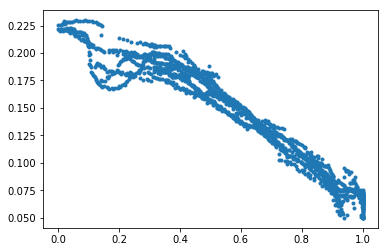

In [17]:
foo = np.load('deviation.npy')

plt.plot(*foo.T, '.')

In [18]:
from scipy.interpolate import splprep, splev, UnivariateSpline, interp1d

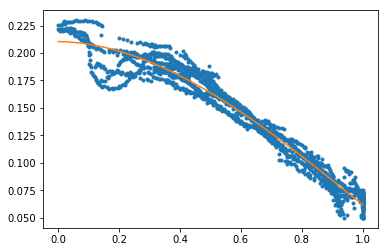

In [19]:
def fitSpline(deprojectedArm):
    sortingLine = deprojectedArm.getSortingLine()
    t = np.linspace(0, 1, sortingLine.shape[0])

    # order the arm along the deprojected XY fit
    o = deprojectedArm.orderAlongPolyLine(
        sortingLine
    )

    # calculate a strictly monotonic t array for points along this arm
    deprojectedT = deprojectedArm.genTFromOrdering(o)

    orderedDeprojectedCloud = (
        deprojectedArm.cleanedCloud[o['pointOrder']]
    )
    r_points, theta_points = rThetaFromXY(
        *arm.normalise(orderedDeprojectedCloud).T,
        mux=0, muy=0
    )
    r_sorting, theta_sorting = rThetaFromXY(
        *(arm.normalise(sortingLine).T)
    )

    thetaFunc = interp1d(t, theta_sorting)

    Sr = UnivariateSpline(deprojectedT, r_points / max(r_points), k=3)
    r_spline = Sr(t) * max(r_points)
    theta_spline = thetaFunc(t)
    xr, yr = xyFromRTheta(r_spline, theta_spline, mux=0, muy=0)

    return {
        'spline_x_y': np.stack((xr, yr), axis=1),
        'spline_r_theta': np.stack((r_spline, theta_spline), axis=1),
        'points_r_theta': np.stack((r_points, theta_points), axis=1),
        'thetaFunc': thetaFunc,
        'spline_t': t,
        'orderedDeprojectedCloud': orderedDeprojectedCloud,
        'deprojectedT': deprojectedT
    }
res = fitSpline(result['deprojectedArms'][0])
plt.plot(res['deprojectedT'], res['points_r_theta'][:, 0], '.')
plt.plot(res['spline_t'], res['spline_r_theta'][:, 0])

(1740, 1) (1740,)
(1740, 1) (1740,)


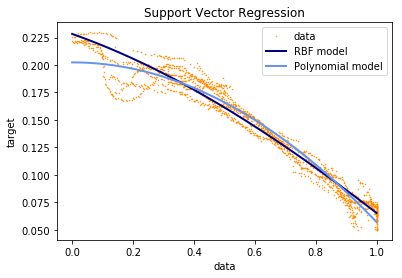

In [28]:
from sklearn.svm import SVR

print(X[:, np.newaxis].shape, y.shape)

# X_ = np.sort(5 * np.random.rand(40, 1), axis=0)
# y_ = np.sin(X_).ravel()
# y_[::5] += 3 * (0.5 - np.random.rand(8))


X_ = res['deprojectedT'].reshape(-1, 1)
y_ = 2 * (y - np.mean(y)) / (np.max(y) - np.min(y))

print(X_.shape, y_.shape)

svr_rbf = SVR(kernel='rbf', gamma=0.1)
svr_poly = SVR(kernel='poly', degree=2)
y_rbf = svr_rbf.fit(X_, y_).predict(X_) / 2 * (np.max(y) - np.min(y)) + np.mean(y)
y_poly = svr_poly.fit(X_, y_).predict(X_) / 2 * (np.max(y) - np.min(y)) + np.mean(y)

# #############################################################################
# Look at the results
lw = 2

plt.plot(X_, y, '.', color='darkorange', label='data', markersize=1)
plt.plot(X_, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X_, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()


In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels as ks

In [22]:
spiral_kernel_clean = (
    ks.ConstantKernel(1) * ks.DotProduct(1) + 
    ks.ConstantKernel(1) * ks.DotProduct(1)**2 +
    ks.ConstantKernel(1) * ks.DotProduct(1)**3
)
spiral_kernal_noise = (
    ks.WhiteKernel(1e-3)
)

spiral_kernel = spiral_kernel_clean + spiral_kernal_noise
gpr = GaussianProcessRegressor(kernel=spiral_kernel, normalize_y=False)

In [35]:
X = res['deprojectedT']
y = res['points_r_theta'][:, 0]

np.save('parametrised_spline_data', np.stack((X, y), axis=1))
y_normed = (y - np.min(y)) / np.max(y - np.min(y))

gpr.fit(X[:, np.newaxis], y_normed)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * DotProduct(sigma_0=1) + 1**2 * DotProduct(sigma_0=1) ** 2 + 1**2 * DotProduct(sigma_0=1) ** 3 + WhiteKernel(noise_level=0.001),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [36]:
print(gpr.kernel_)

0.00316**2 * DotProduct(sigma_0=281) + 1.22**2 * DotProduct(sigma_0=0.000241) ** 2 + 0.398**2 * DotProduct(sigma_0=0.0151) ** 3 + WhiteKernel(noise_level=0.00295)


In [37]:
X_ = X[:, np.newaxis]
y_pred_normed, y_std_normed = gpr.predict(res['spline_t'][:, np.newaxis], return_std=True)

# undo the normalisation
y_pred = y_pred_normed * np.max(y - np.min(y)) + np.min(y)
y_std = y_std_normed * np.max(y - np.min(y))

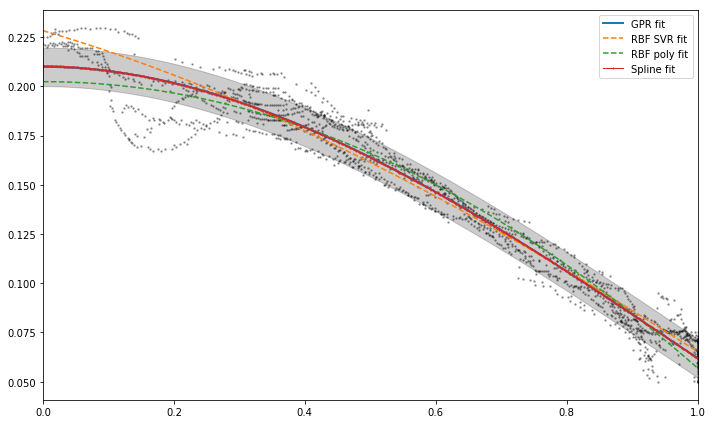

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, '.', c='k', alpha=0.3, markersize=3)
plt.plot(res['spline_t'], y_pred, linewidth=2, label='GPR fit')
plt.fill_between(
    res['spline_t'],
    y_pred - 1 * y_std,
    y_pred + 1 * y_std,
    alpha=0.2, color='k'
)
plt.plot(X, y_rbf, '--', label='RBF SVR fit')
plt.plot(X, y_poly, '--', label='RBF poly fit')
plt.plot(res['spline_t'], res['spline_r_theta'][:, 0], '.-', markersize=2, linewidth=1, label='Spline fit')

plt.xlim(X_.min(), X_.max())
plt.tight_layout()
plt.legend()

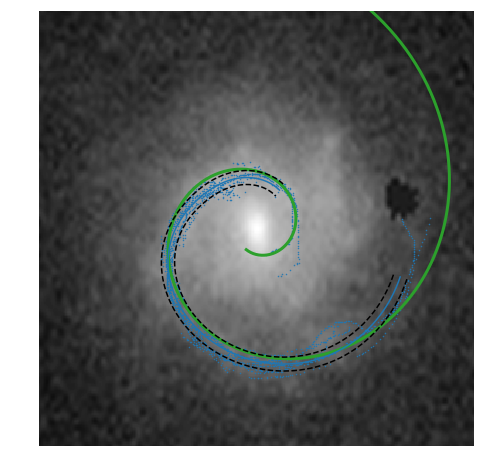

In [30]:
# get the points
theta_ = res['thetaFunc'](res['spline_t'].reshape(-1))

x_, y_ = xyFromRTheta(y_pred, theta_)
x_lower, y_lower = xyFromRTheta(y_pred - y_std, theta_)
x_upper, y_upper = xyFromRTheta(y_pred + y_std, theta_)


plt.figure(figsize=(8, 8))

# show the galaxy
plt.imshow(deprojectedImage, cmap='gray', origin='lower', extent=[-0.5, 0.5, -0.5, 0.5])

# plot the points
for i, dpjArm in enumerate(result['deprojectedArms'][:1]):
    points = dpjArm.normalise(dpjArm.cleanedCloud)
    plt.plot(*points.T, '.', c='C{}'.format(i), markersize=1)

# plot the log spiral
plt.plot(*spiral.T, c='C2', linewidth=3)

# plot the spline and errors
plt.plot(x_, y_, '-')
plt.plot(x_lower, y_lower, '--', c='k')
plt.plot(x_upper, y_upper, '--', c='k')

plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.axis('off')
None